In [1]:
### Team Name: NobodyExpectsTheSystemIntegration
### Design and Programming by Mojtaba Valipour @ Shiraz University, Udacity 

In [1]:
'''
Resources:
    - https://github.com/burgalon/deep-learning-traffic-lights/blob/master/train.py
    - https://www.tensorflow.org
'''
print('Copyright is important @2017')

Copyright is important @2017


In [2]:
import tensorflow as tf
import os
%matplotlib inline
#os.environ["CUDA_VISIBLE_DEVICES"] = '0,1,2'
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4579580963129292120
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 12051077530
locality {
  bus_id: 1
}
incarnation: 1114668678313933405
physical_device_desc: "device: 0, name: GeForce GTX TITAN X, pci bus id: 0000:0a:00.0"
, name: "/gpu:1"
device_type: "GPU"
memory_limit: 12051077530
locality {
  bus_id: 1
}
incarnation: 9115430034224958163
physical_device_desc: "device: 1, name: GeForce GTX TITAN X, pci bus id: 0000:09:00.0"
, name: "/gpu:2"
device_type: "GPU"
memory_limit: 12049085236
locality {
  bus_id: 1
}
incarnation: 9135827158769917494
physical_device_desc: "device: 2, name: GeForce GTX TITAN X, pci bus id: 0000:06:00.0"
, name: "/gpu:3"
device_type: "GPU"
memory_limit: 12047777792
locality {
  bus_id: 1
}
incarnation: 16516969795125883881
physical_device_desc: "device: 3, name: GeForce GTX TITAN X, pci bus id: 0000:05:00.0"
]


# Config

In [3]:
import os

from keras.layers import Dense, Dropout, Flatten, MaxPooling2D, Convolution2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras.optimizers import Adam

NUM_CHANNELS = 3
IMAGE_WIDTH = 224 
IMAGE_HEIGHT = 224 
NUM_CLASSES = 5

Using TensorFlow backend.


# Helper function

In [4]:
# keras image generator
def get_generator(directory, train):
    if train:
        datagen = ImageDataGenerator(
          rescale=1./255,
          shear_range=0.2,
          zoom_range=0.2,
          horizontal_flip=True)
    else:
        datagen = ImageDataGenerator(rescale=1./255)
    
    return datagen.flow_from_directory(
        directory=directory,
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size=8,
        class_mode='categorical')

In [68]:
import matplotlib.pyplot as plt
def plotSpecialTool(data,labels,samples2Visualize=12,factors=[2,6], figsize=(20,12), grayFlag=False, thr=0.0):
    # samples2Visualize = 12 # sample 12 random number
    # factors = [2,6] # indicate two factors for number of samples
    assert np.prod(np.array(factors))==samples2Visualize, "%rx%r is not equal to %r" % (factors[0],factors[1],samples2Visualize)
    figure = plt.figure(figsize=figsize)
    nLimit = data.shape[0]
    for i in range(1,samples2Visualize+1):
        img = figure.add_subplot(factors[0],factors[1],i)
        # randomly sample an image from train set
        imgID = np.random.randint(nLimit-1)
        image = data[imgID]
        #image = image[60:150,:]
        if grayFlag:
            plt.imshow(image.reshape(image.shape[0],image.shape[1]), cmap=plt.get_cmap('gray'))
        else:
            plt.imshow(image)
        img.set_title(labels[imgID],fontsize=7)
        plt.axis('off')
#plotSpecialTool(centerImgs,labelsCSV["label"],factors=[3,4],thr=0.0,grayFlag=False) 

In [31]:
# load images
import cv2
import numpy as np
from scipy import misc
def loadImg(imgLoc):
    imageLocation = imgLoc
    image = misc.imread(imageLocation) #cv2.imread(imageLocation) # BGR
    #b,g,r = cv2.split(image)       # get b,g,r
    #image = cv2.merge([r,g,b])     # switch it to rgb

    if (image is None):
        print(imageLocation)
     
    image = cv2.resize(image, (224, 224))
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image
#numSample = 12
#centerImgs = np.array([loadImg(imgLoc) for imgLoc in labelsCSV['filename'][0:numSample]])

# Dataset

In [5]:
directory = './data/'
train_generator = get_generator(directory+'train', True)
validation_generator = get_generator(directory+'val', False)

Found 1583 images belonging to 5 classes.
Found 56 images belonging to 5 classes.


# Model 

In [6]:
model = Sequential([
  Convolution2D(16, (3, 3), padding='same', strides=(2, 2), input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUM_CHANNELS), activation='relu'),
  MaxPooling2D(pool_size=(3, 3)),
  Dropout(0.2),

  Convolution2D(32, (3, 3), padding='same', activation='relu'),
  MaxPooling2D(pool_size=(3, 3)),
  Dropout(0.2),

  Convolution2D(64, (3, 3), padding='same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.2),

  Flatten(),
  Dense(128, activation='tanh'),
  Dropout(0.3),
  Dense(NUM_CLASSES, activation='softmax'),
])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 112, 112, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 37, 37, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        18496     
__________

In [7]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
model.compile(optimizer=Adam(lr=0.0003), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
filepath="./logs/-{epoch:02d}-val_acc-{val_acc:.2f}.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=False, mode='auto')
tensorboard = keras.callbacks.TensorBoard(log_dir='./tensorboard', histogram_freq=0, write_graph=True, write_images=True)
callbacks = [checkpoint, tensorboard]

In [ ]:
import h5py
model.fit_generator(
  train_generator,
  steps_per_epoch=train_generator.n,
  epochs=200,
  validation_data=validation_generator,
  validation_steps=validation_generator.n,
  callbacks=callbacks,
)

Epoch 1/200
1583/1583 [==============================] - 245s - loss: 0.4643 - acc: 0.8015 - val_loss: 1.2079 - val_acc: 0.3906
Epoch 2/200
1583/1583 [==============================] - 241s - loss: 0.3072 - acc: 0.8726 - val_loss: 1.3638 - val_acc: 0.3527
Epoch 3/200
1583/1583 [==============================] - 241s - loss: 0.2039 - acc: 0.9152 - val_loss: 1.2134 - val_acc: 0.3281
Epoch 4/200
1583/1583 [==============================] - 243s - loss: 0.1235 - acc: 0.9539 - val_loss: 1.5791 - val_acc: 0.5781
Epoch 5/200
1583/1583 [==============================] - 243s - loss: 0.0888 - acc: 0.9700 - val_loss: 0.8843 - val_acc: 0.6674
Epoch 6/200
1583/1583 [==============================] - 241s - loss: 0.0726 - acc: 0.9760 - val_loss: 1.3511 - val_acc: 0.3929
Epoch 7/200
1583/1583 [==============================] - 241s - loss: 0.0545 - acc: 0.9817 - val_loss: 2.4971 - val_acc: 0.3929
Epoch 8/200
1583/1583 [==============================] - 242s - loss: 0.0497 - acc: 0.9839 - val_loss: 2

/home/mvalipour/.conda/envs/udacityProjects/lib/python3.5/site-packages/ipykernel/__main__.py:11: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/mvalipour/.conda/envs/udacityProjects/lib/python3.5/site-packages/ipykernel/__main__.py:11: UserWarning: Update your `evaluate_generator` call to the Keras 2 API: `evaluate_generator(<keras.pre..., steps=56)`


[0.24239802627458371, 0.9419642857142857]

In [61]:
# load best weights for the model
from keras.models import load_model
model = load_model('./logs/-67-val_acc-0.48.hdf5')

In [62]:
model.evaluate_generator(validation_generator, steps=len(validation_generator.filenames))

[1.6066111515143089, 0.4799107142857143]

In [36]:
labels = ['green', 'nolight', 'red', 'unidentified', 'yellow']

In [63]:
# test the best model on the test pictures
%matplotlib inline
import glob
testDir = directory+'test/'
files = glob.glob(testDir+'*')
imgL = []
tlStatusL = []
for file in files: 
    # load image
    img = loadImg(file)
    # predict 
    tlStatus = model.predict(img.reshape(1,img.shape[0],img.shape[1],img.shape[2]),batch_size=1)
    # plot
    imgL.append(img)
    tlStatusL.append(labels[np.argmax(tlStatus)])
    #print(labels[np.argmax(tlStatus)])
    #plt.imshow(img)

In [59]:
print(len(tlStatusL))

104


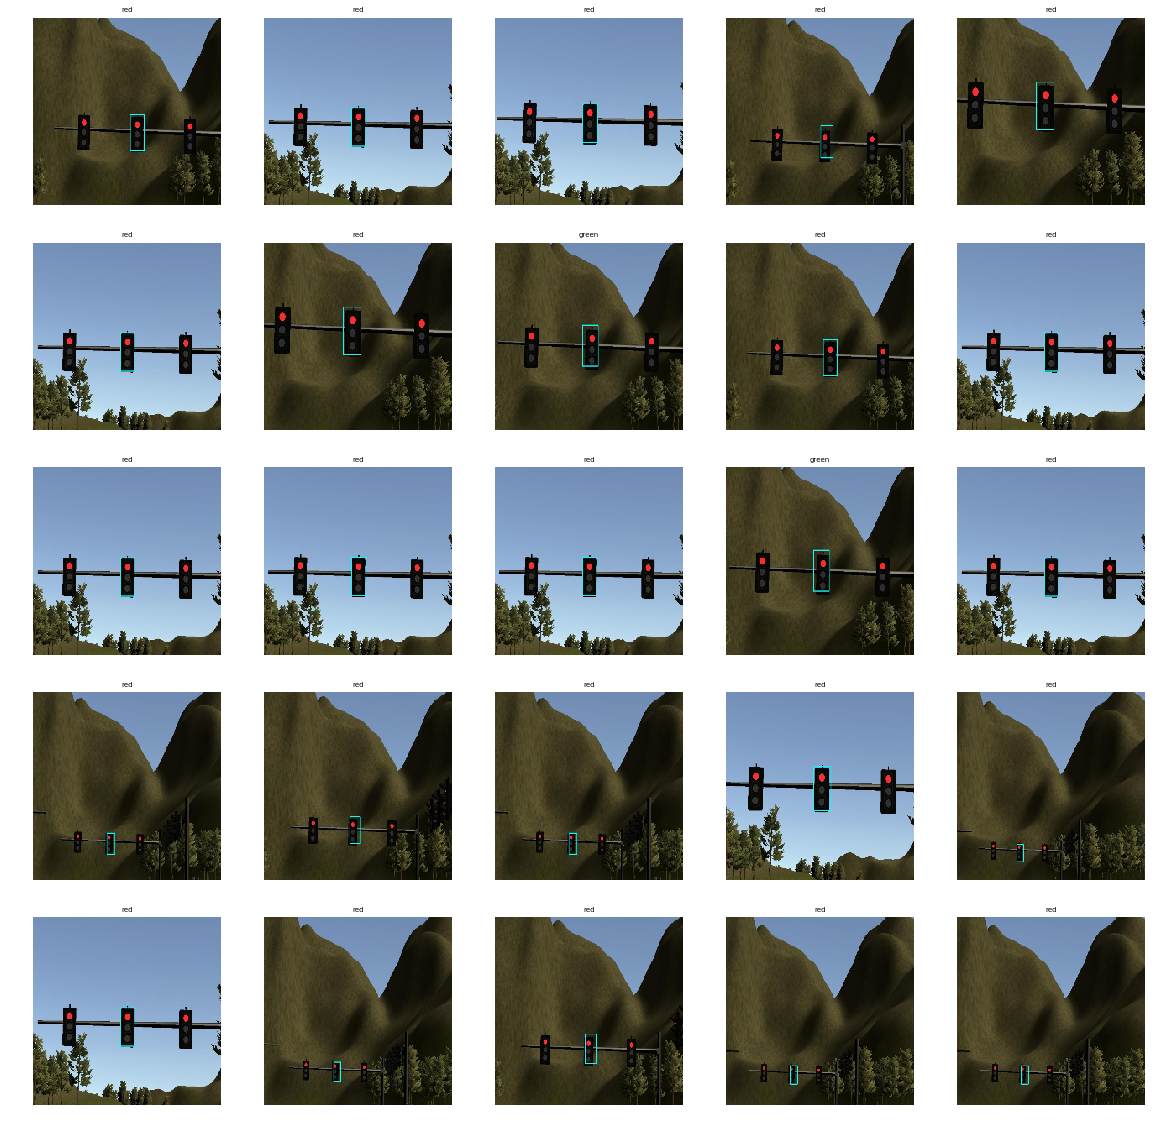

In [73]:
plotSpecialTool(np.array(imgL[0:25]),np.array(tlStatusL[0:25]),samples2Visualize=25,factors=[5,5], figsize=(20,20),thr=0.0,grayFlag=False) 

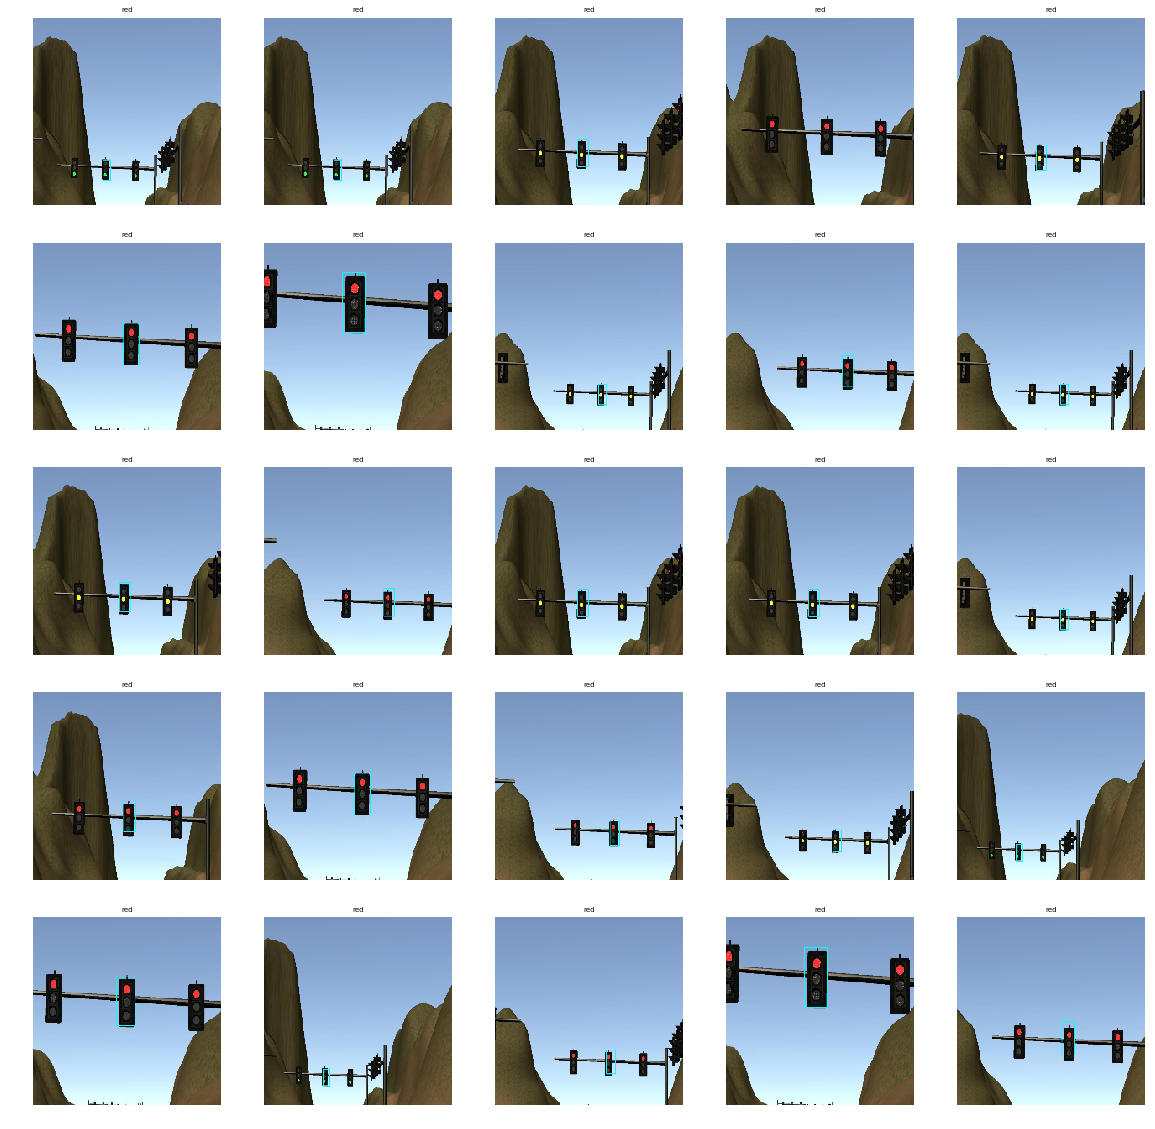

In [74]:
plotSpecialTool(np.array(imgL[25:50]),np.array(tlStatusL[25:50]),samples2Visualize=25,factors=[5,5], figsize=(20,20),thr=0.0,grayFlag=False) 

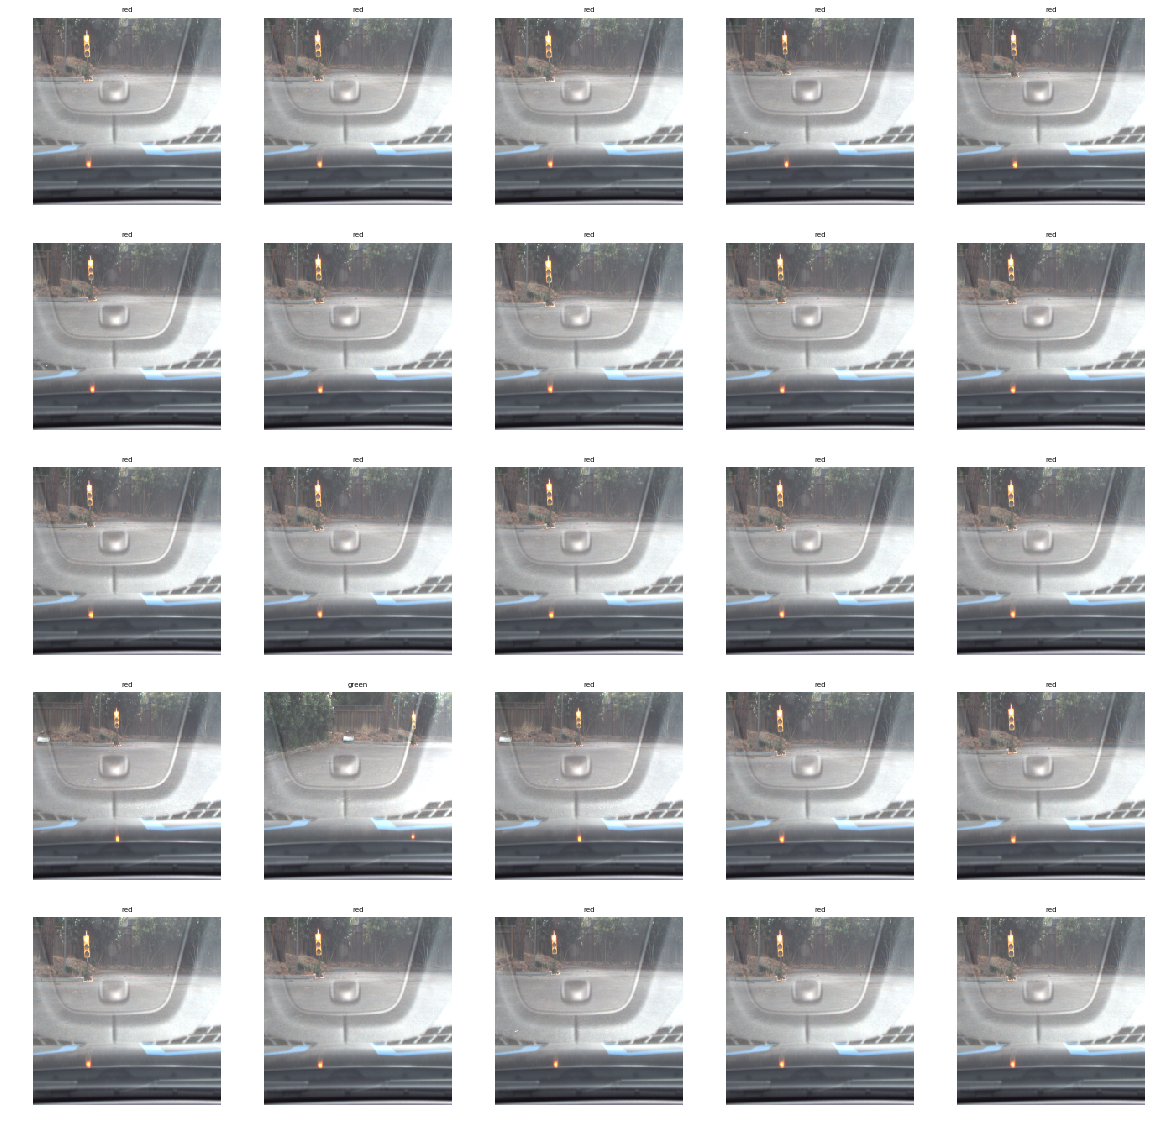

In [75]:
plotSpecialTool(np.array(imgL[50:75]),np.array(tlStatusL[50:75]),samples2Visualize=25,factors=[5,5], figsize=(20,20),thr=0.0,grayFlag=False) 

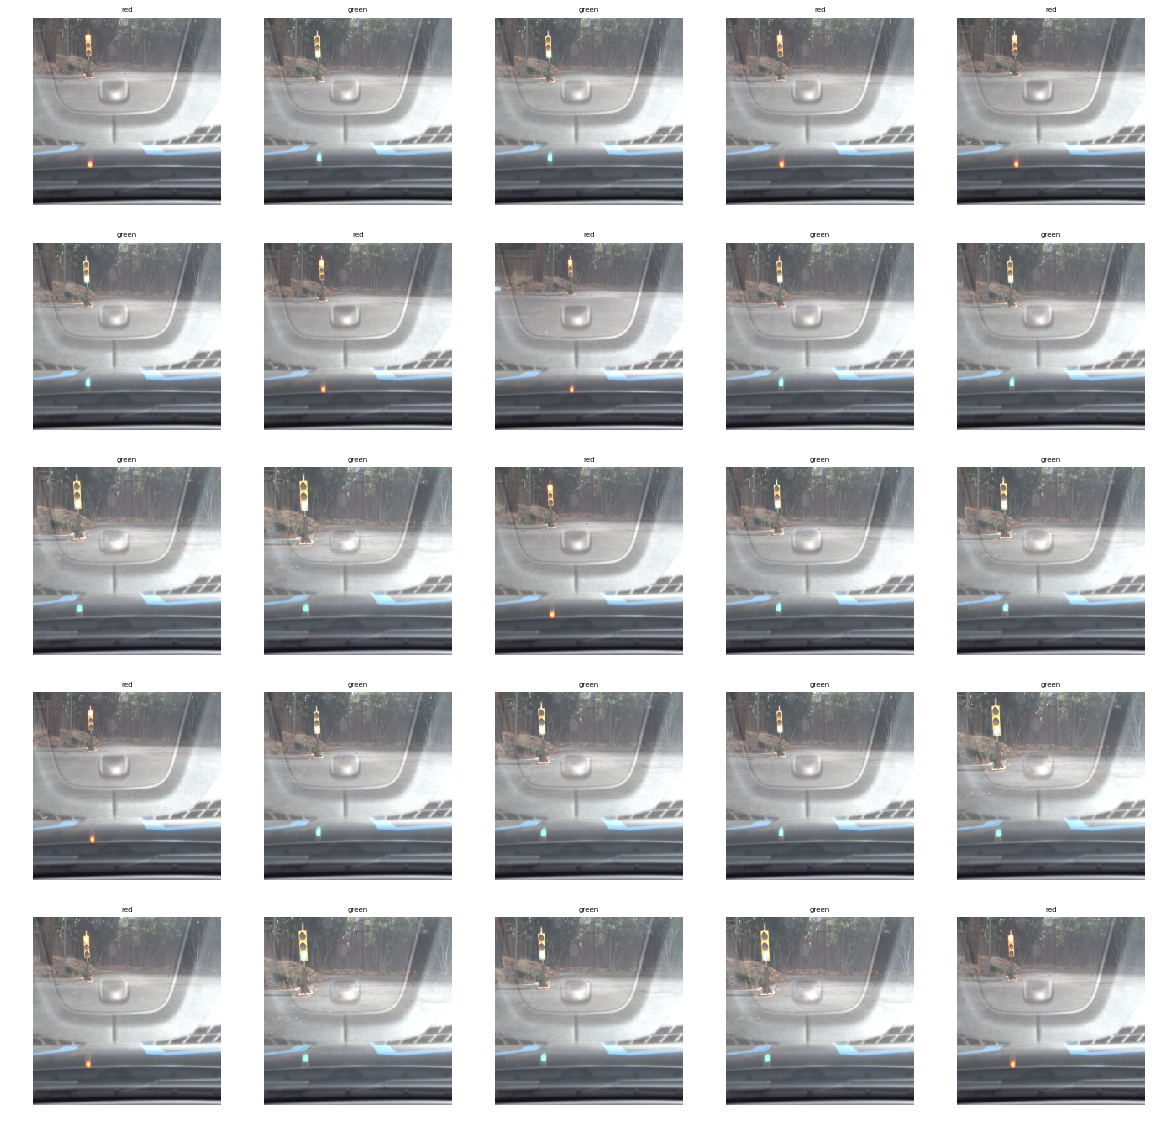

In [76]:
plotSpecialTool(np.array(imgL[75:100]),np.array(tlStatusL[75:100]),samples2Visualize=25,factors=[5,5], figsize=(20,20),thr=0.0,grayFlag=False) 